In [1]:
# 0. 사용할 패키지 불러오기
import keras
import numpy as np
import os
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
%matplotlib inline

class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

look_back = 40

In [2]:
# 1. 데이터셋 생성하기
# signal_data = np.cos(np.arange(1600)*(20*np.pi/1000))[:,None]
signal_data = fdr.DataReader('005930')
signal_data.dropna(inplace=True)

In [3]:
window_size = 10 
data_size = 5

def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

raw_df = signal_data
dfx = raw_df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]

x = dfx.values.tolist()
y = dfy.values.tolist()

data_x = []
data_y = []
for i in range(len(y) - window_size):
    _x = x[i : i + window_size] # 다음 날 종가(i+windows_size)는 포함되지 않음
    _y = y[i + window_size]     # 다음 날 종가
    data_x.append(_x)
    data_y.append(_y)
print(_x, "->", _y)

[[0.9125138427453904, 0.854338842974324, 0.9094972067028944, 0.19091183541077128, 0.893773582816888], [0.91362126245746, 0.8574380165280399, 0.916201117317412, 0.20681266354570604, 0.9103714605015764], [0.9302325581385047, 0.880165289255289, 0.9374301675967179, 0.2546618488788422, 0.9313954389021816], [0.9501661129557584, 0.8884297520651979, 0.9474860335184945, 0.180009724030284, 0.9380345899760569], [0.954595791804037, 0.8904958677676751, 0.9508379888257532, 0.2108606922868629, 0.9446737410499323], [0.9534883720919674, 0.8904958677676751, 0.9541899441330121, 0.19805442544644514, 0.9402476403340154], [0.9490586932436887, 0.8853305785114821, 0.9396648044682239, 0.21310014042560985, 0.9302889137232024], [0.9379844961229923, 0.8770661157015732, 0.9318435754179533, 0.20146691626642527, 0.918117136754431], [0.9313399778505743, 0.8688016528916644, 0.9284916201106944, 0.14301659564217833, 0.9136910360385141], [0.9191583610178082, 0.8729338842966189, 0.9251396648034356, 0.16873935434117626, 0.

In [4]:
dfx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5999 entries, 1997-04-21 to 2021-04-14
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5999 non-null   float64
 1   High    5999 non-null   float64
 2   Low     5999 non-null   float64
 3   Volume  5999 non-null   float64
 4   Close   5999 non-null   float64
dtypes: float64(5)
memory usage: 281.2 KB


In [5]:
dfy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5999 entries, 1997-04-21 to 2021-04-14
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   5999 non-null   float64
dtypes: float64(1)
memory usage: 93.7 KB


In [6]:
train_size = int(len(data_y) * 0.7)
val_size = int(len(data_y) * 0.1)
test_size = len(data_y) - train_size - val_size
x_train = np.array(data_x[0 : train_size])
y_train = np.array(data_y[0 : train_size])

x_test = np.array(data_x[train_size : len(data_x)])
y_test = np.array(data_y[train_size : len(data_y)])

x_val = np.array(data_x[train_size+test_size : len(data_x)])
y_val = np.array(data_y[train_size+test_size : len(data_y)])

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((4192, 10, 5), (4192, 1), (1797, 10, 5), (1797, 1), (598, 10, 5), (598, 1))

In [7]:
len(data_y), train_size, test_size, val_size

(5989, 4192, 1199, 598)

In [9]:
# # 2. 모델 구성하기
# model = Sequential()
# for i in range(2):
#     model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True, return_sequences=True))
#     model.add(Dropout(0.3))
# model.add(LSTM(32, batch_input_shape=(1, look_back, 1), stateful=True))
# model.add(Dropout(0.3))
# model.add(Dense(1))
# 모델 생성
model = Sequential()
model.add(LSTM(units=32, activation='relu', return_sequences=True, input_shape=(window_size, data_size)))
model.add(Dropout(0.1))
model.add(LSTM(units=16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=16))
model.add(Dense(units=1))
model.summary()

# 3. 모델 학습과정 설정하기
# model.compile(loss='mean_squared_error', optimizer='adam')
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# 4. 모델 학습시키기
custom_hist = CustomHistory()
custom_hist.init()
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

model.fit(x_train, y_train, epochs=50, batch_size=32, callbacks=[custom_hist, checkpoint, earlystopping], validation_data=(x_val, y_val))
pred_y = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10, 32)            4864      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 8,289
Trainable params: 8,289
Non-trainable params: 0
____________________________________________________

127/131 [============================>.] - ETA: 0s - loss: 8.3234e-05 - mse: 1.6647e-04
Epoch 00023: val_loss improved from 0.00047 to 0.00043, saving model to tmp\ckeckpointer.ckpt
131/131 [==============================] - 1s 10ms/step - loss: 8.2464e-05 - mse: 1.6493e-04 - val_loss: 4.2594e-04 - val_mse: 8.5188e-04
Epoch 24/50
131/131 [==============================] - ETA: 0s - loss: 7.6652e-05 - mse: 1.5330e-04
Epoch 00024: val_loss improved from 0.00043 to 0.00040, saving model to tmp\ckeckpointer.ckpt
131/131 [==============================] - 1s 11ms/step - loss: 7.6652e-05 - mse: 1.5330e-04 - val_loss: 4.0364e-04 - val_mse: 8.0728e-04
Epoch 25/50
126/131 [===========================>..] - ETA: 0s - loss: 8.8394e-05 - mse: 1.7679e-04
Epoch 00025: val_loss did not improve from 0.00040
131/131 [==============================] - 1s 8ms/step - loss: 8.7186e-05 - mse: 1.7437e-04 - val_loss: 4.7265e-04 - val_mse: 9.4531e-04
Epoch 26/50
130/131 [============================>.] - ETA: 

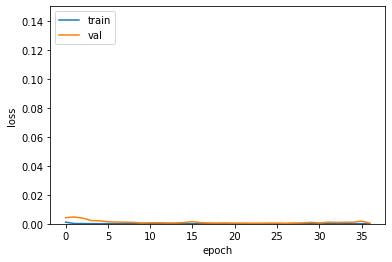

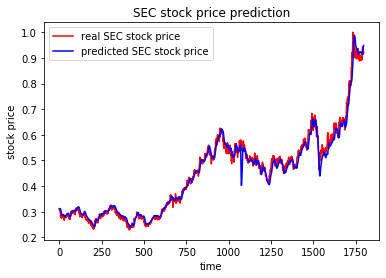

Tomorrow's SEC price : [86331.92512359] KRW


In [11]:
# 5. 학습과정 살펴보기
plt.plot(custom_hist.train_loss)
plt.plot(custom_hist.val_loss)
plt.ylim(0.0, 0.15)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Visualising the results
plt.figure()
plt.plot(y_test, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Tomorrow's SEC price :", raw_df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')


In [12]:

pd.DataFrame(pred_y)

,0
0,0.312123
1,0.311819
2,0.311740
3,0.311881
4,0.312064
...,...
1792,0.931294
1793,0.937137
1794,0.941648
1795,0.945457


In [14]:
b_test

,0,pred
0,0.308864,0.312123
1,0.308864,0.311819
2,0.310192,0.311740
3,0.306209,0.311881
4,0.304660,0.312064
...,...,...
1792,0.930289,0.931294
1793,0.918117,0.937137
1794,0.913691,0.941648
1795,0.922543,0.945457


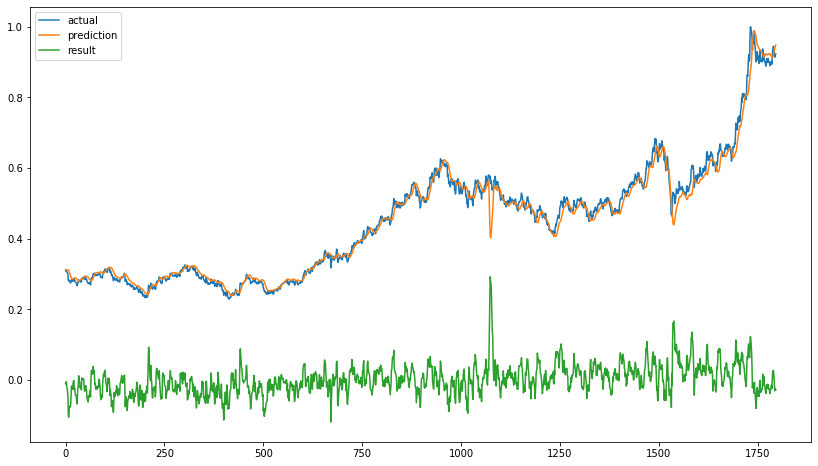

In [17]:
b_test = pd.DataFrame(y_test, columns=['Close'])
b_test['pred'] = pd.DataFrame(pred_y)
b_test['result'] = (b_test['Close']-b_test['pred'])/b_test['Close']
b_test.columns = ['actual', 'prediction', 'result']
p = b_test.plot(figsize=(14,8))
# p = b_test.plot(secondary_y='result', figsize=(14,8))